<a href="https://colab.research.google.com/github/MatthewGuile/tool-lyrics-nlp/blob/main/tool_lyrics_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating an NLP pipeline to analyse Tool lyrics in python**

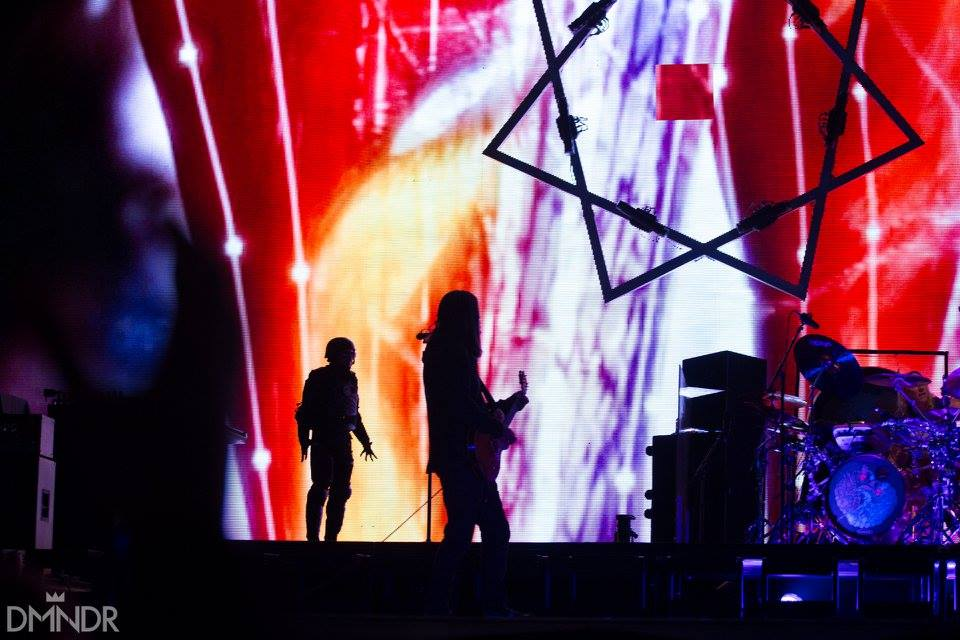</br> *Photo by [DMNDR](http://x.dmndr.com/boston-calling-dmndr-answers-the-complete-festival-photo-review/)*

In 2019, the critically acclaimed progressive-rock band Tool released the album Fear Inoculum after a 13-year hiatus between releases. Although Fear Inoculum came out prior to the covid-19 pandemic, the lyrics seem prescient at times. For example - the titular track, Fear Inoculum, starts with "*Immunity, long overdue. Contagion, I exhale you*", phrases that could easily apply to life during the pandemic.  Tool's vocalist, Maynard James Keenan, has long been lauded as an excellent lyricist. However, Tool fans are notorious for using messages boards to unpack and deciper the meaning conveyed by their songs, often to the chagrin of the [band](https://www.nme.com/news/music/tool-4-1204846). 

This notebook provides a Natural Language Processing pipeline for Tool's lyrics, which were extracted using [LyricsGenius](https://lyricsgenius.readthedocs.io/en/master/), a Python client for the Genius.com API. The process involves cleaning the extracted dataset and engineering features that will enable the lyrics be analysed using an NLP framework, such as [spaCy](https://spacy.io/) or [NLTK](https://www.nltk.org/). 

# Fetching the data

LyricsGenius is a Python client that allows users to easily extract data from Genius.com, a popular lyrics website. The Tool lyrics dataset was extracted using this method and saved to a github repository. For more information, please read the LyricsGenius [documentation](https://lyricsgenius.readthedocs.io/en/master/setup.html). If you wish to follow along, you can find the dataset [here](https://github.com/MatthewGuile/tool-lyrics-nlp/blob/main/files/Lyrics_Tool.json). 

We start by loading the .json file containing the data extracted via LyricsGenius. After this, we view the data to identify what pre-processing is required to prepare the data for analysis.

In [158]:
# fetch data from Github

import json 
import requests

url = "https://raw.githubusercontent.com/MatthewGuile/tool-lyrics-nlp/main/files/Lyrics_Tool.json"
resp = requests.get(url)
data = json.loads(resp.text)

# view data to determine what further processing is required
data

{'alternate_names': [],
 'api_path': '/artists/19326',
 'current_user_metadata': {'excluded_permissions': ['edit',
   'edit_images',
   'edit_names',
   'edit_anything',
   'merge',
   'sort_artist_songs',
   'follow',
   'view_contribution_opportunities',
   'edit_translation_artist',
   'see_short_id'],
  'interactions': {'following': False},
  'permissions': ['view_activity_stream']},
 'description': {'plain': "Tool is an enigmatic heavy metal band from Los Angeles, California. Members include vocalist Maynard James Keenan, guitarist Adam Jones, drummer Danny Carey, and bassist Justin Chancellor. Chancellor replaced Paul D'Amour in 1995.\n\nThe band emerged with its first (and only) EP, Opiate (1992), and followed that up with their debut studio album, Undertow (1993), during the age of early 1990s grunge, and made their success by headlining Lollapalooza festivals aimed at that genre. After the alternative rock scene receded from the mainstream American ear, Tool continued into art

# Cleaning the data

Most of the data required is located in the 'songs' key of the dataset. Subsequently, we load 'songs' as pandas dataframe and view its keys to explore what further processing is required.


In [159]:
# load 'song' key to pandas dataframe

import pandas as pd

df0 = pd.DataFrame(data['songs'])

# view keys to determine what further processing is required
df0.keys()

Index(['annotation_count', 'api_path', 'artist_names', 'full_title',
       'header_image_thumbnail_url', 'header_image_url', 'id',
       'lyrics_owner_id', 'lyrics_state', 'path', 'pyongs_count',
       'song_art_image_thumbnail_url', 'song_art_image_url', 'stats', 'title',
       'title_with_featured', 'url', 'primary_artist', 'apple_music_id',
       'apple_music_player_url', 'description', 'embed_content',
       'featured_video', 'lyrics_placeholder_reason', 'recording_location',
       'release_date', 'release_date_for_display', 'current_user_metadata',
       'album', 'custom_performances', 'description_annotation',
       'featured_artists', 'lyrics_marked_complete_by', 'media',
       'producer_artists', 'song_relationships', 'verified_annotations_by',
       'verified_contributors', 'verified_lyrics_by', 'writer_artists',
       'artist', 'lyrics'],
      dtype='object')

We see many options when looking at the keys of the dataframe. However, we will only be using  'title', 'lyrics' and 'release_date" in this notebook. 

In [160]:
# select relevant columns and save to new dataframe
df = df0[['title', 'lyrics', 'release_date']]

We now need to extract the data from the df0['album'] key because the album name is nested within the df0['album'] key. Let's extract album names from df0['album'] by using a for loop to add them to a list called album_list. We then add album_list as a column to the dataframe. 

This initially presented with a [SettingWithCopyWarning](https://www.dataquest.io/blog/settingwithcopywarning/) from Pandas. However, further investigation indicated that this was a false positive and therefore we bypass the warning. 

In [161]:
# scrape albums from df0['album']

pd.options.mode.chained_assignment = None # this bypasses the pandas SettingWithCopyWarning, which had a false positive 

album_list = []

for i in range(len(df0['album'])):
    try:
        album_list.append(df0['album'][i]['name'])
    except:
        album_list.append(None)
        continue

# create column in df for albums 
df['album'] = album_list

# view dataframe
df

,title,lyrics,release_date,album
0,Sober,There's a shadow just behind me\nShrouding eve...,1993-04-06,Undertow
1,Lateralus,Black\nThen\nWhite are\nAll I see\nIn my infan...,2001-05-15,Lateralus
2,Ænema,"Hey, hey, hey, hey, hey, hey, hey, hey, hey\n\...",1996-09-17,Ænima
3,Forty Six & 2,"Join in my—\nJoin in, my child, and listen\nDi...",1996-09-17,Ænima
4,The Pot,Who are you to wave your finger?\nYou must've ...,2006-05-02,"10,000 Days"
...,...,...,...,...
83,Ænema [Demo],"Hey, hey, hey, hey\n(hey, hey, hey, hey, hey, ...",1994-01-01,None
84,Crawl Away (Demo),Crawled away from me\nSlipped away from me\nTr...,1991-12-21,72826
85,Part of Me (Demo),"I know you well, you are a part of me\nI know ...",1991-12-21,72826
86,Flood (Live),All I knew and all I believed\nAre crumbling i...,None,Sober - Tales from the Darkside


The album column above contains demos and live albums, which means that there are duplicates of songs in the dataset that may skew the analysis. Let's filter the dataframe to only select Tool's six main releases. Please note that the band's first release Opiate is an EP containing fewer songs than the other releases. 





In [162]:
# select the albums required for analysis and drop irrelevant data
relevant_albums = ['Opiate', 'Undertow', 'Ænima', 'Lateralus', '10,000 Days', 'Fear Inoculum']

df = df[df['album'].isin(relevant_albums)]

# view dataframe 
df

,title,lyrics,release_date,album
0,Sober,There's a shadow just behind me\nShrouding eve...,1993-04-06,Undertow
1,Lateralus,Black\nThen\nWhite are\nAll I see\nIn my infan...,2001-05-15,Lateralus
2,Ænema,"Hey, hey, hey, hey, hey, hey, hey, hey, hey\n\...",1996-09-17,Ænima
3,Forty Six & 2,"Join in my—\nJoin in, my child, and listen\nDi...",1996-09-17,Ænima
4,The Pot,Who are you to wave your finger?\nYou must've ...,2006-05-02,"10,000 Days"
...,...,...,...,...
62,Part of Me,"Yeah\nReady\n\nI know you well, you are a part...",1992-03-10,Opiate
63,Lipan Conjuring,2EmbedShare URLCopyEmbedCopy,2006-05-02,"10,000 Days"
65,(-) Ions,,1996-09-17,Ænima
66,Cesaro Summability,EmbedShare URLCopyEmbedCopy,1996-09-17,Ænima


# Data cleaning continued 

Now we remove the unnecessary whitespaces present in the dataset and we convert the text to lower case.


In [163]:
# remove whitespace

import re
def remove_whitespace(text):
   
    pattern = re.compile(r'\s+')
    remove_whitespace = re.sub(pattern, ' ', text)
    text = remove_whitespace.replace('?', ' ? ').replace(')', ') ')
    lower_text = text.lower()
    return lower_text

# apply function to df
df['lyrics'] = df['lyrics'].apply(lambda x: remove_whitespace(x))

df

,title,lyrics,release_date,album
0,Sober,there's a shadow just behind me shrouding ever...,1993-04-06,Undertow
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus
2,Ænema,"hey, hey, hey, hey, hey, hey, hey, hey, hey so...",1996-09-17,Ænima
3,Forty Six & 2,"join in my— join in, my child, and listen digg...",1996-09-17,Ænima
4,The Pot,who are you to wave your finger ? you must've...,2006-05-02,"10,000 Days"
...,...,...,...,...
62,Part of Me,"yeah ready i know you well, you are a part of ...",1992-03-10,Opiate
63,Lipan Conjuring,2embedshare urlcopyembedcopy,2006-05-02,"10,000 Days"
65,(-) Ions,,1996-09-17,Ænima
66,Cesaro Summability,embedshare urlcopyembedcopy,1996-09-17,Ænima


Contractions such as, *aren't* instead of *are not *or are frequently used in lyrics. In the next block of code, we create a dictionary of contractions with their associated expanded form called contraction_map. We then create a function that tokenises the text input, which in this case is the lyrics data. Then we check for whether the token is found in the contraction map dictionary. If the token is present, it is replaced with the expanded form of the word. 

In [164]:
# fix contractions 

contraction_map = {
    "'bout": "about",
    "ain't": "is not",
    "'round": "around",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "get'chu": "get you",
    "gonna": "going to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "kinda": "kind of",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "l.a": "los angeles",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "'til": "until",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "whatcha": "what are you",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}


# The code for expanding contraction words
def expand_contractions(text, contraction_mapping = contraction_map):

    # Tokenizing text into tokens.
    list_of_tokens = text.split(' ')

    # Checking for whether the given token matches with the Key & replacing word with key's value.

    # Check whether word is in list_of_tokens or not.
    for word in list_of_tokens:
        # Check whether found word is in dictionary "Contraction Map" or not as a key.
        if word in contraction_map:
            # If Word is present in both dictionary & list_Of_tokens, replace that word with the key value.
            list_of_tokens = [item.replace(word, contraction_map[word]) for item in list_of_tokens]

    # Converting list of tokens to String.
    string_of_tokens = ' '.join(str(e) for e in list_of_tokens)
    return string_of_tokens

df['lyrics'] = df['lyrics'].apply(lambda x: expand_contractions(x, contraction_mapping=contraction_map))

df.head(5)




,title,lyrics,release_date,album
0,Sober,there is a shadow just behind me shrouding eve...,1993-04-06,Undertow
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus
2,Ænema,"hey, hey, hey, hey, hey, hey, hey, hey, hey so...",1996-09-17,Ænima
3,Forty Six & 2,"join in my— join in, my child, and listen digg...",1996-09-17,Ænima
4,The Pot,who are you to wave your finger ? you must ha...,2006-05-02,"10,000 Days"


"""Removing all the special characters except the one that is passed within
       the regex to match, as they have imp meaning in the text provided.


    arguments:
         input_text: "text" of type "String".

    return:
        value: Text with removed special characters that don't require.

    Example:
    Input : Hello, K-a-j-a-l. Thi*s is $100.05 : the payment that you will recieve! (Is this okay?)
    Output :  Hello, Kajal. This is $100.05 : the payment that you will recieve! Is this okay?

   """

In [165]:
# The code for removing special characters
import string as st

def clean_data(text):
  
    # The formatted text after removing not necessary punctuations.
    regex_strip = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text)
    specific_strip = re.sub(r"[0-9]+[a-zA-Z]+ [a-zA-Z]+",'', regex_strip)
    remove_text = specific_strip.replace("embedshare urlcopyembedcopy", "")
    return  ("".join([ch for ch in remove_text if ch not in st.punctuation]))

df['lyrics'] = df['lyrics'].apply(lambda x: clean_data(x))

df
# # final punctionation clean
# def remove_punct(text):
#     return ("".join([ch for ch in text if ch not in st.punctuation]))

# df['lyrics'] = df['lyrics'].apply(lambda x: remove_punct(x))

# df


,title,lyrics,release_date,album
0,Sober,there is a shadow just behind me shrouding eve...,1993-04-06,Undertow
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus
2,Ænema,hey hey hey hey hey hey hey hey hey some say t...,1996-09-17,Ænima
3,Forty Six & 2,join in my join in my child and listen digging...,1996-09-17,Ænima
4,The Pot,who are you to wave your finger you must have...,2006-05-02,"10,000 Days"
...,...,...,...,...
62,Part of Me,yeah ready i know you well you are a part of m...,1992-03-10,Opiate
63,Lipan Conjuring,,2006-05-02,"10,000 Days"
65,(-) Ions,,1996-09-17,Ænima
66,Cesaro Summability,,1996-09-17,Ænima


In [ ]:
# feature engineering

lyrics = df[["title", 'lyrics', "release_date", 'album']].copy()


lyrics['word_count'] = lyrics['lyrics'].apply(lambda x : len(x.split()))
lyrics['unique_count'] = lyrics['lyrics'].apply(lambda x: len(set(w for w in x.split())))
lyrics['lexical_diversity'] = lyrics['unique_count'] / lyrics['word_count']
lyrics = lyrics.loc[lyrics.word_count > 0]
lyrics.head()


lyrics.sort_values('unique_count', ascending=False)



In [167]:
#import dependencies
import plotly.express as px

fig = px.box(lyrics, x="album", y="word_count", color = "album")
fig2 = px.box(lyrics, x="album", y="unique_count", color = "album")
fig3 = px.box(lyrics, x="album", y="lexical_diversity", color = "album")

fig

In [169]:
lyrics['release_date'] = pd.to_datetime(lyrics['release_date'])


lyrics

#album_names = ["Opiate", "Undertow", "Ænima", "Lateralus", "10,000 Days", "Fear Inoculum"]

# #lyrics = lyrics.reindex(columns = album_names)

# def get_word_count(text): 
#   word_count = lyrics.groupby('album').sum()
#   return word_count


# album_words = lyrics['lyrics'].apply(lambda x: get_word_count(x))

# album_words

,title,lyrics,release_date,album,word_count,unique_count,lexical_diversity
0,Sober,there is a shadow just behind me shrouding eve...,1993-04-06,Undertow,282,86,0.304965
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus,333,132,0.396396
2,Ænema,hey hey hey hey hey hey hey hey hey some say t...,1996-09-17,Ænima,576,164,0.284722
3,Forty Six & 2,join in my join in my child and listen digging...,1996-09-17,Ænima,312,114,0.365385
4,The Pot,who are you to wave your finger you must have...,2006-05-02,"10,000 Days",325,116,0.356923
5,Schism,i know the pieces fit because i watched them f...,2001-05-15,Lateralus,223,113,0.506726
6,Fear Inoculum,immunity long overdue contagion i exhale you n...,2019-08-07,Fear Inoculum,164,82,0.500000
7,"10,000 Days (Wings Pt 2)",we listen to the tales and romanticize how we ...,2006-05-02,"10,000 Days",402,189,0.470149
8,Stinkfist,something has to change undeniable dilemma bor...,1996-09-17,Ænima,255,115,0.450980
9,Rosetta Stoned,alrighty then picture this if you will 10 to 2...,2006-05-02,"10,000 Days",707,266,0.376238


In [170]:
from nltk import word_tokenize, WhitespaceTokenizer

def tokenize(text):
    text = re.split('\s+' ,text)
    return text
lyrics['tokens'] = lyrics['lyrics'].apply(lambda x : tokenize(x))
lyrics



,title,lyrics,release_date,album,word_count,unique_count,lexical_diversity,tokens
0,Sober,there is a shadow just behind me shrouding eve...,1993-04-06,Undertow,282,86,0.304965,"[there, is, a, shadow, just, behind, me, shrou..."
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus,333,132,0.396396,"[black, then, white, are, all, i, see, in, my,..."
2,Ænema,hey hey hey hey hey hey hey hey hey some say t...,1996-09-17,Ænima,576,164,0.284722,"[hey, hey, hey, hey, hey, hey, hey, hey, hey, ..."
3,Forty Six & 2,join in my join in my child and listen digging...,1996-09-17,Ænima,312,114,0.365385,"[join, in, my, join, in, my, child, and, liste..."
4,The Pot,who are you to wave your finger you must have...,2006-05-02,"10,000 Days",325,116,0.356923,"[who, are, you, to, wave, your, finger, you, m..."
5,Schism,i know the pieces fit because i watched them f...,2001-05-15,Lateralus,223,113,0.506726,"[i, know, the, pieces, fit, because, i, watche..."
6,Fear Inoculum,immunity long overdue contagion i exhale you n...,2019-08-07,Fear Inoculum,164,82,0.500000,"[immunity, long, overdue, contagion, i, exhale..."
7,"10,000 Days (Wings Pt 2)",we listen to the tales and romanticize how we ...,2006-05-02,"10,000 Days",402,189,0.470149,"[we, listen, to, the, tales, and, romanticize,..."
8,Stinkfist,something has to change undeniable dilemma bor...,1996-09-17,Ænima,255,115,0.450980,"[something, has, to, change, undeniable, dilem..."
9,Rosetta Stoned,alrighty then picture this if you will 10 to 2...,2006-05-02,"10,000 Days",707,266,0.376238,"[alrighty, then, picture, this, if, you, will,..."


In [174]:

from textblob import TextBlob

sentiment = []
#Iterate for each row of lyrics and append the scores
for i in lyrics.index:
    blob=TextBlob(df['lyrics'].iloc[i])
    sentiment.append(blob.sentiment[0])
#Create a column for the sentiment score
lyrics['sentiment'] = sentiment

albums = lyrics.groupby('album').mean()


albums.sort_values('sentiment', ascending=False)

,word_count,unique_count,lexical_diversity,sentiment
album,,,,
Fear Inoculum,165.142857,67.714286,0.495477,0.124721
"10,000 Days",310.888889,133.444444,0.451157,0.091517
Lateralus,217.500000,82.500000,0.392135,0.032810
Ænima,334.272727,127.818182,0.420014,0.004115
Undertow,327.600000,96.700000,0.301401,-0.018922
Opiate,240.000000,61.000000,0.246540,-0.077424


In [96]:
import matplotlib.pyplot as plt


def plot_sentiment_by_album(album):
    
    grouped = lyrics.groupby('album')[
          ['negative (%)', 'neutral (%)', 'positive (%)',
            'mixed (%)']].mean().reset_index()
    
    grouped[grouped['track_title'] ==       track_title].plot_bokeh.bar(
          xlabel='Sentiment Score', xticks=[0, 1, 2, 3],
          title='Sentiment score for track: '+ str(track_title))
neg_sentiments = grouped[grouped['track_title'].isin(full_catalog['1989'])]['negative (%)']
pos_sentiments = grouped[grouped['track_title'].isin(full_catalog['1989'])]['positive (%)']
fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(np.arange(len(neg_sentiments)),
        -neg_sentiments,
        facecolor='red', alpha=0.7,
        edgecolor='black',
        label='negative')
ax.barh(np.arange(len(pos_sentiments)),
        pos_sentiments,
        facecolor='green', alpha=0.7,
        edgecolor='black',
        label='positive')

ax.set_yticks(np.arange(len(pos_sentiments)))
ax.set_yticklabels(full_catalog['1989'], 
                   fontsize=12)
ax.set_ylabel('Track Title', fontsize=18)
ax.set_xlabel('Negative - Positive Sentiment (%)',
              fontsize=18)

ax.set_title('Average Sentiment Scores for Taylor Swift Album: 1989',
             fontsize=25)
ax.legend(loc='best')
plt.show()

NameError: ignored

In [ ]:
# albums_uw = lyrics[['Album','unique_count']].groupby("Album").describe()
# albums_uw["released"] = [2015,2009,2013,2005,2017,2007,2011,2003]
# albums_uw = albums_uw.sort_values('released')
# albums_uw

In [ ]:
# albums_diversity = lyrics[['Album','lexical_diversity']].groupby("Album").describe()
# albums_diversity["released"] = [2015,2009,2013,2005,2017,2007,2011,2003]
# albums_diversity = albums_diversity.sort_values('released')
# albums_diversity